In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from scipy.stats import zscore

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Activation

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [4]:
train_data = h5py.File('Signs_Data_Training.h5')
test_data = h5py.File('Signs_Data_Testing.h5')

In [5]:
train_data.keys() , test_data.keys()


(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [6]:
X_train = train_data['train_set_x']
y_train = train_data['train_set_y']
X_test = test_data['test_set_x']
y_test = test_data['test_set_y']

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1080, 64, 64, 3), (1080,), (120, 64, 64, 3), (120,))

## Quality check

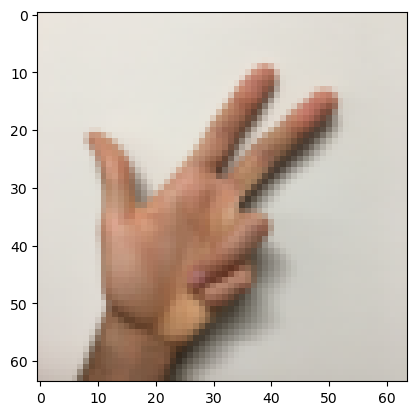

3


In [10]:
index = 540
plt.imshow(X_train[index])
plt.show();
print(y_train[index])

In [11]:
# convert them all to arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
X_train = X_train.reshape(1080,-1)
X_train = pd.DataFrame(X_train)
X_test = X_test.reshape(120,-1)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [13]:
# check if the pixels are in the range of 0 and 255
for i in range (X_train.shape[1]):
    for j in range (X_train.shape[0]):
       if X_train[i][j] > 255: 
           print(f'Error at i= {i} and error at j = {j} value = {X_train[i,j]}')
 


In [14]:
# change the y_train and y_test to label
y_train.columns = ['Label']
y_test.columns = ['Label']

In [15]:
# Check if the training label have balanced data
y_train['Label'].value_counts()

Label
5    180
0    180
2    180
4    180
1    180
3    180
Name: count, dtype: int64

In [16]:
# check if the test label have balanced data
y_test['Label'].value_counts()

Label
0    20
5    20
1    20
3    20
4    20
2    20
Name: count, dtype: int64

In [18]:
# Normalize the data
X_train_norm = zscore(X_train) 
X_train_norm = X_train_norm.reshape(1080, 64, 64, 3)

In [19]:
X_test_norm = zscore(X_test)
X_test_norm = X_test_norm.reshape(120,64,64,3)

In [20]:
# one hot encode train labels
y_train_norm = pd.get_dummies(y_train['Label'])
y_train_norm.shape

(1080, 6)

In [21]:
# one hot encode test label
y_test_norm = pd.get_dummies(y_test['Label'])
y_test_norm.shape

(120, 6)

In [22]:
# create model
def create_model(input_shape, learning_rate = 0.001):
 X_input = Input(input_shape)

# layer 1
 X = Conv2D(16, (3, 3), padding= 'same', activation='relu', name='Conv1')(X_input)
 X = MaxPool2D((2, 2), name='Pool1')(X)
 X = Dropout(0.2)(X)
 #layer 2

 X = Conv2D(32, (3,3), padding = 'same', activation = 'relu', name = 'Conv2')(X)
 X = MaxPool2D((2,2), name = 'Pool2')(X)
 X = Dropout(0.2)(X)

 # Fully connected layers
 X = Flatten()(X)
 X = Dense(64, activation = 'relu', name = 'fc1')(X)
 X = Dropout(0.2)(X)

# output layer
 X = Dense(6, activation = 'softmax', name = 'output')(X)

 model= Model(inputs = X_input, outputs= X)
 model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
 return model

In [33]:
# instantiate model
M1 = create_model(X_train_norm.shape[1:])

In [34]:
# train
M1.fit(X_train_norm, y_train_norm, epochs = 150,batch_size =16,verbose = 1)

Epoch 1/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4417 - loss: 1.4277
Epoch 2/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7997 - loss: 0.5270
Epoch 3/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9239 - loss: 0.2524
Epoch 4/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9462 - loss: 0.1717
Epoch 5/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9394 - loss: 0.1483
Epoch 6/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9777 - loss: 0.0831
Epoch 7/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9588 - loss: 0.1138
Epoch 8/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9726 - loss: 0.0740
Epoch 9/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9732 - loss: 0.0565
Epoch 10/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0366
Epoch 11/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0422
Epoch 12/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

In [25]:
# check the summary
M1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,589,492 (6.06 MB)

 Trainable params: 529,830 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,059,662 (4.04 MB)

In [26]:
# training accuracy
y_train_pred = M1.predict(X_train_norm)
y_train_pred = np.argmax(y_train_pred, axis = 1)
print(accuracy_score(y_train, y_train_pred))



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1.0


In [27]:
# testing accuracy
y_test_pred = M1.predict(X_test_norm)
y_test_pred = np.argmax(y_test_pred, axis = 1)
print(accuracy_score(y_test, y_test_pred))



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0.9666666666666667


In [28]:
preds = M1.evaluate(X_test_norm, y_test_norm, batch_size=32, verbose=1, sample_weight=None)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9627 - loss: 0.0628


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


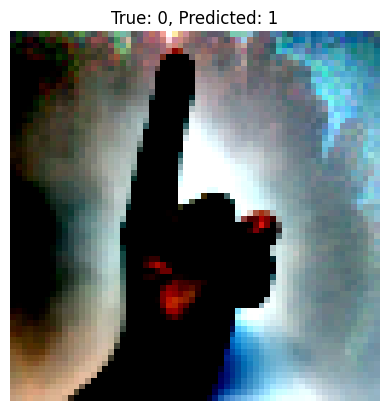

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


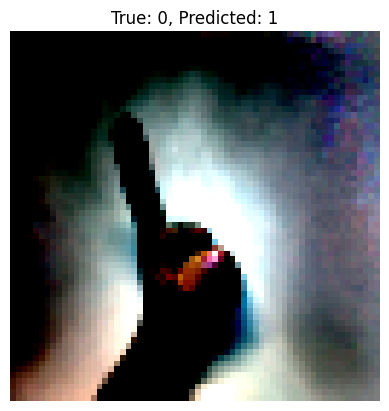

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


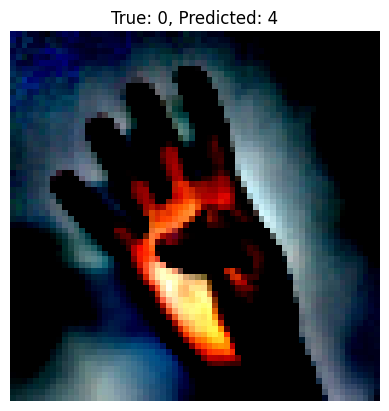

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


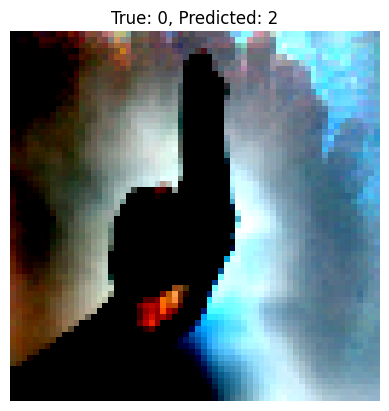

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


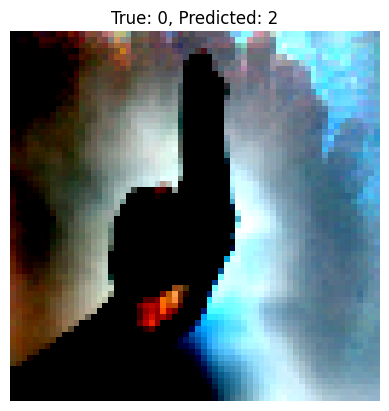

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


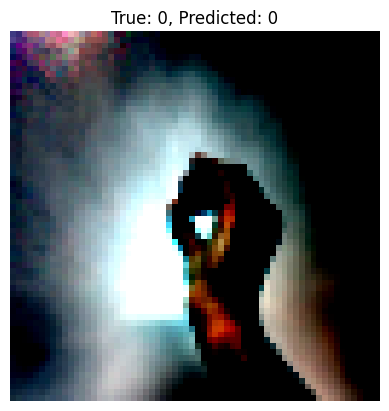

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


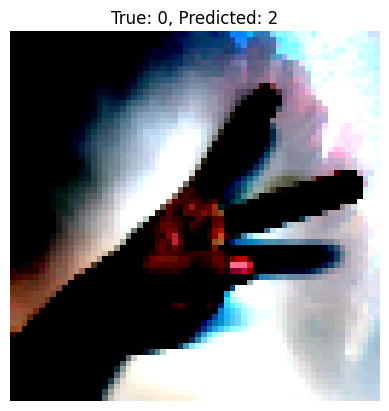

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


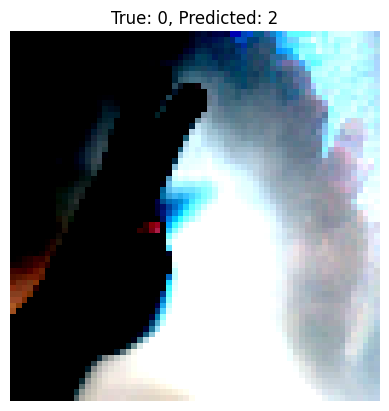

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


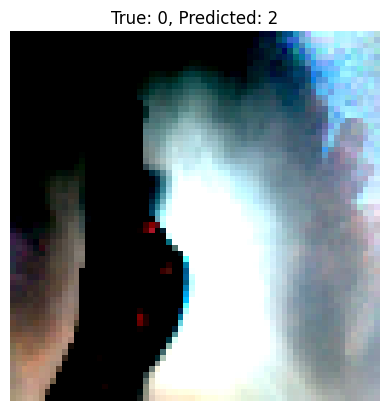

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


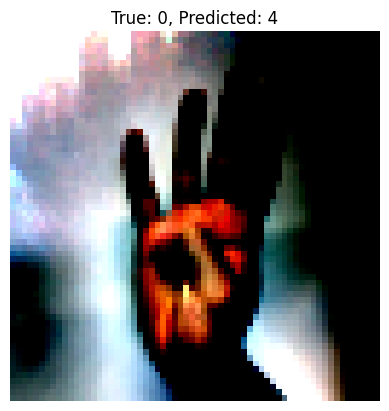

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


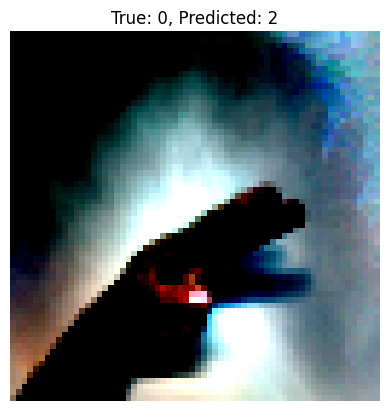

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


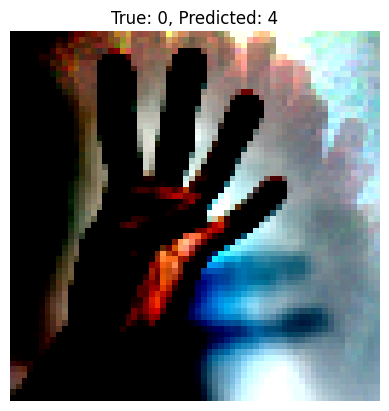

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


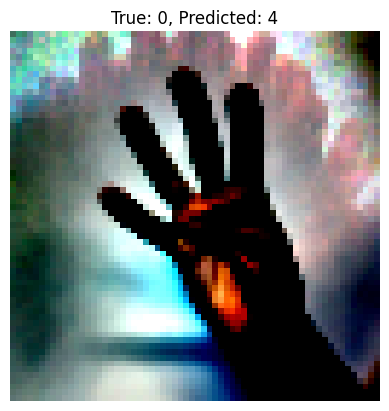

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


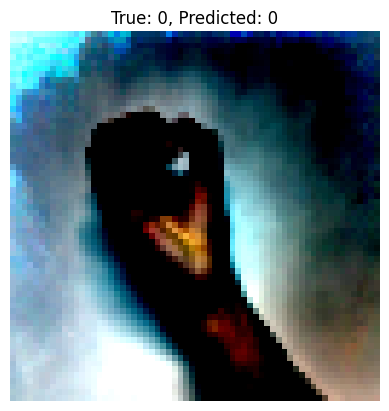

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


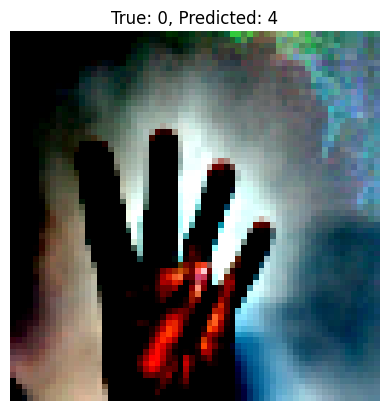

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


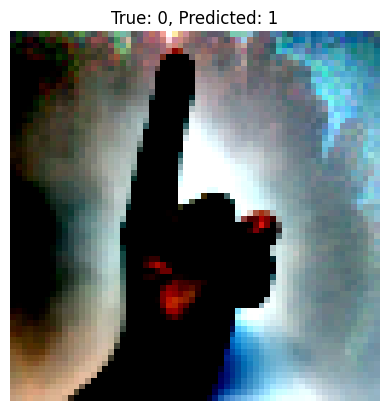

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


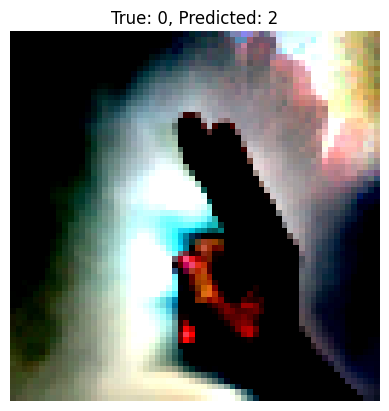

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


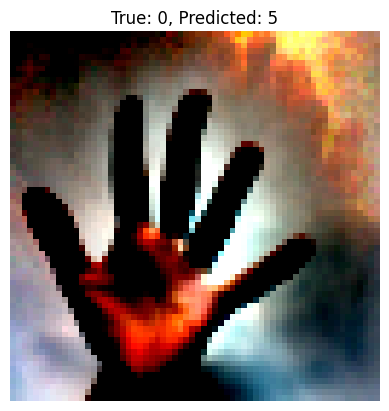

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


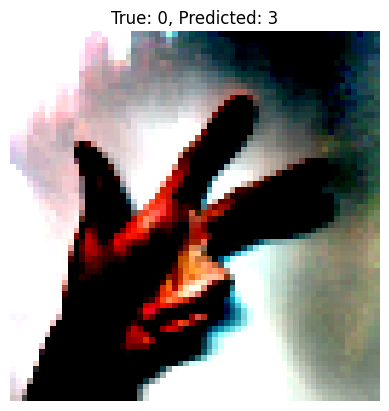

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


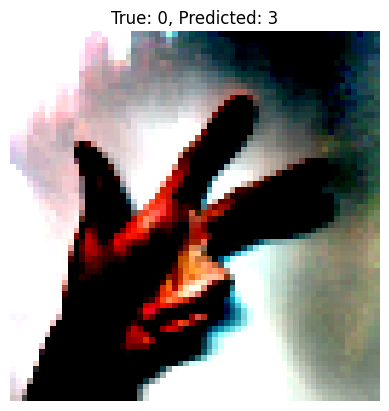

In [31]:
# visualize to evaluate the predictions
for i in range(20): 
    idx = np.random.randint(len(X_test_norm))
    image = X_test_norm[idx]
    true_label = np.argmax(y_test.iloc[idx].values)
    pred_label = np.argmax(M1.predict(np.expand_dims(image, axis=0)))

    plt.imshow(image)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()
